In [1]:
# %pip install umap
# %pip install umap-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

In [2]:
base_path = 'C:/Eugenio/Maestria/DMEyF/'

dataset_path = base_path + 'datasets/'
dataset_file = 'competencia_01_fe.csv'

modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'

semillas = [122219, 109279, 400391, 401537, 999961]

In [3]:
data = pd.read_csv(dataset_path + dataset_file)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [4]:
df_train = data[data['foto_mes'] == 202104].copy()

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [5]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

### Random forest distance

In [6]:
# tomamos todos los baja y voy a tomar 2000 continua (probe tambien tomar 10.000 continua pero no me sirvio mucho)

np.random.seed(semillas[3])
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

In [7]:
Xtrain_rf.shape

(4171, 855)

In [9]:
ytrain_rf.shape

(4171,)

In [10]:
# entrenamos el random forest (imputando missings con la mediana)

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

# model = RandomForestClassifier(n_estimators=100,
#                                max_features=20,
#                                min_samples_leaf=400,
#                                random_state=109279)

# model.fit(Xtrain_rf_imp, ytrain_rf)

In [32]:
# entrenamos el random forest (sin imputar missings)

# scikit-learn added missing values support for random forest in v.1.4
# https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_4_0.html
# "When training every individual tree, the splitter evaluates each potential threshold with the missing values going to the left and right nodes."

model = RandomForestClassifier(n_estimators=100,
                               max_features=0.35,
                               max_depth=28,
                               min_samples_split = 199,
                               min_samples_leaf=95,
                               random_state=semillas[3])

model.fit(Xtrain_rf, ytrain_rf)

RandomForestClassifier(max_depth=28, max_features=0.35, min_samples_leaf=95,
                       min_samples_split=199, random_state=401537)

In [33]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf)

In [34]:
md.shape

(4171, 4171)

In [35]:
md

array([[0.  , 0.44, 1.  , ..., 0.66, 1.  , 1.  ],
       [0.44, 0.  , 1.  , ..., 0.48, 1.  , 1.  ],
       [1.  , 1.  , 0.  , ..., 1.  , 1.  , 0.97],
       ...,
       [0.66, 0.48, 1.  , ..., 0.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 0.  , 1.  ],
       [1.  , 1.  , 0.97, ..., 1.  , 1.  , 0.  ]])

### Embedding

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

c:\Users\eaneg\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1858: UserWarning:

using precomputed metric; inverse_transform will be unavailable

c:\Users\eaneg\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



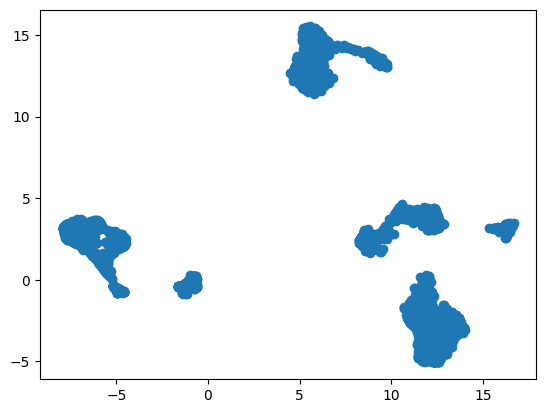

In [36]:
embedding_rf = UMAP(
  n_components=2, 
  n_neighbors=50,
  metric="precomputed",
  random_state=semillas[3],
).fit_transform(md)

# min_dist=0.3, # 0.1 default

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

In [16]:
# este tampoco

# embedding_rf = UMAP(
#   n_components=10, # POR QUE 2 DIMENSIONES NOMAS? PODRIAMOS PROBAR DEJAR MAS DIMENSIONES TOTAL EL CLUSTERING PUEDE USAR MUCHAS DIMENSIONES.
#   n_neighbors=25,
#   metric="precomputed",
#   random_state=semillas[3],
# ).fit_transform(md)

In [17]:
# embedding_rf = UMAP(
#   n_components=10, # POR QUE 2 DIMENSIONES NOMAS? PODRIAMOS PROBAR DEJAR MAS DIMENSIONES TOTAL EL CLUSTERING PUEDE USAR MUCHAS DIMENSIONES.
#   n_neighbors=25,
#   min_dist=0.3, # 0.1 default
#   metric="precomputed",
#   random_state=semillas[3],
# ).fit_transform(md)

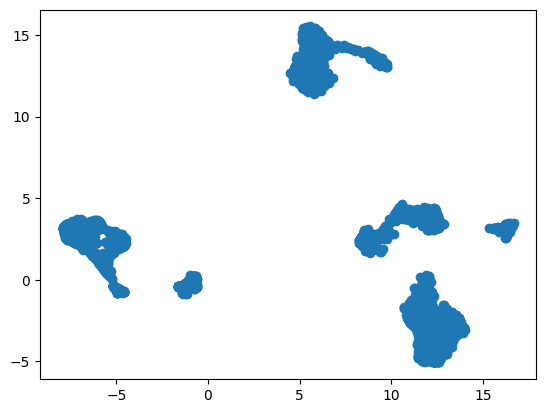

In [37]:
# las primeras 2 dimensiones:

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

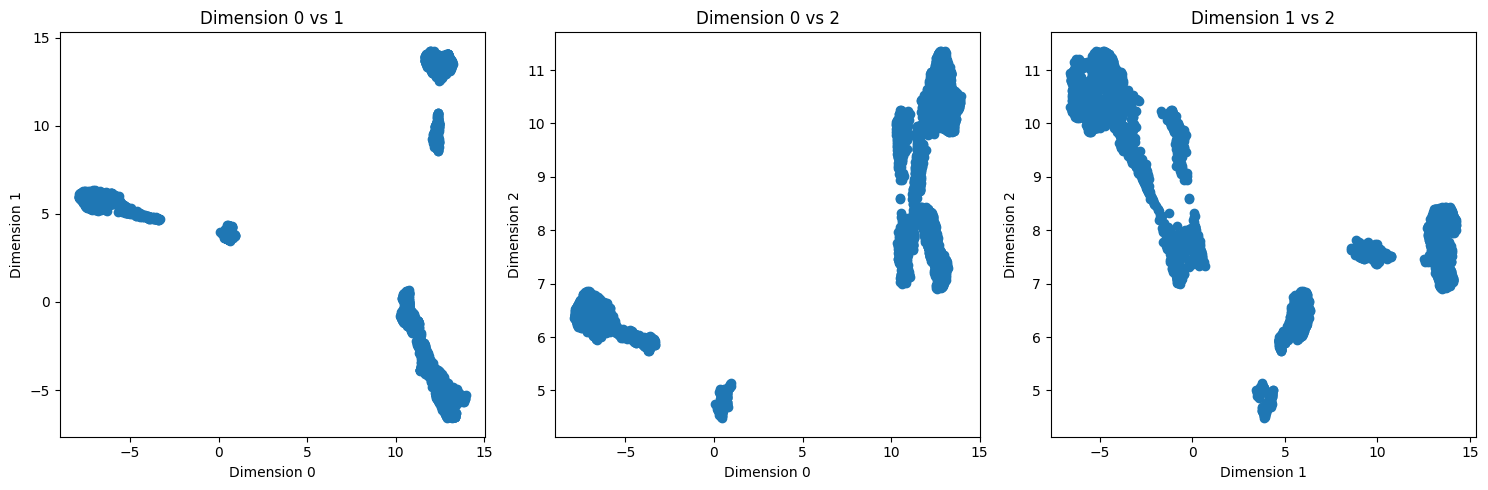

In [12]:
# 3 dimensiones:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first two dimensions (0 vs 1)
axs[0].scatter(embedding_rf[:, 0], embedding_rf[:, 1])
axs[0].set_title('Dimension 0 vs 1')
axs[0].set_xlabel('Dimension 0')
axs[0].set_ylabel('Dimension 1')

# Plot the first and third dimensions (0 vs 2)
axs[1].scatter(embedding_rf[:, 0], embedding_rf[:, 2])
axs[1].set_title('Dimension 0 vs 2')
axs[1].set_xlabel('Dimension 0')
axs[1].set_ylabel('Dimension 2')

# Plot the second and third dimensions (1 vs 2)
axs[2].scatter(embedding_rf[:, 1], embedding_rf[:, 2])
axs[2].set_title('Dimension 1 vs 2')
axs[2].set_xlabel('Dimension 1')
axs[2].set_ylabel('Dimension 2')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
import plotly.graph_objects as go

# Create a 3D scatter plot with no color distinction
fig = go.Figure(data=[go.Scatter3d(
    x=embedding_rf[:, 0],
    y=embedding_rf[:, 1],
    z=embedding_rf[:, 2],
    mode='markers',
    marker=dict(
        size=5,   # Adjust point size
        color='blue',  # Single color for all points
        opacity=0.8
    )
)])

# Set labels and make the plot larger
fig.update_layout(
    title='3D Scatter Plot of Embeddings',
    scene=dict(
        xaxis_title='Dimension 0',
        yaxis_title='Dimension 1',
        zaxis_title='Dimension 2'
    ),
    width=800,  # Make the plot bigger
    height=600
)

# Show the plot
fig.show()

UMAP Parameteres:

The most important parameter is n_neighbors - the number of approximate nearest neighbors used to construct the initial high-dimensional graph. It effectively controls how UMAP balances local versus global structure - low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail.

The second parameter we’ll investigate is min_dist, or the minimum distance between points in low-dimensional space. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings. Larger values of min_dist will make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.

While most applications of UMAP involve projection from high-dimensional data, the projection from 3D serves as a useful analogy to understand how UMAP prioritizes global vs local structure depending on its parameters. As n_neighbors increases, UMAP connects more and more neighboring points when constructing the graph representation of the high-dimensional data, which leads to a projection that more accurately reflects the global structure of the data. At very low values, any notion of global structure is almost completely lost. As the min_dist parameter increases, UMAP tends to "spread out" the projected points, leading to decreased clustering of the data and less emphasis on global structure.

1. Hyperparameters really matter
Choosing good values isn't easy, and depends on both the data and your goals (eg, how tightly packed the projection ought to be). This is where UMAP's speed is a big advantage - By running UMAP multiple times with a variety of hyperparameters, you can get a better sense of how the projection is affected by its parameters.

2. Cluster sizes in a UMAP plot mean nothing
Just as in t-SNE, the size of clusters relative to each other is essentially meaningless. This is because UMAP uses local notions of distance to construct its high-dimensional graph representation.

3. Distances between clusters might not mean anything
Likewise, the distances between clusters is likely to be meaningless. While it's true that the global positions of clusters are better preserved in UMAP, the distances between them are not meaningful. Again, this is due to using local distances when constructing the graph.

Chat GPT:

When you reduce your 600 variables down to two dimensions using UMAP and then apply DBSCAN, you can reasonably interpret that points grouped closely together in the 2D projection likely belong to the same cluster. UMAP is good at maintaining local structure, so within each cluster, points should still reflect some meaningful similarity.

However, when looking at the relative distances between clusters in the UMAP projection, you need to be cautious. As you mentioned, while you may observe two clusters that appear close to each other and a third cluster farther away, the proximity of those clusters in 2D doesn’t necessarily mean the first two clusters are more similar than the third one. UMAP’s distortion of global structure can make these distances less meaningful.

In short: within-cluster proximity is likely meaningful, but between-cluster distances in the UMAP projection should be interpreted with caution

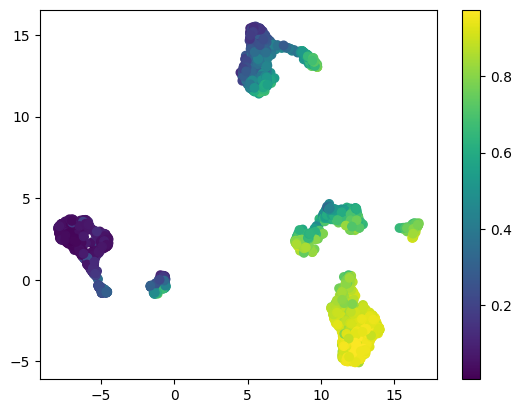

In [38]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

In [15]:
# NO LOGRO QUE ASIGNE COLORES SEGUN PROB_BAJA SI LE QUIERO PONER UNA ESCALA DE COLORES DETERMINADA (EJ VIRIDIS)

import plotly.graph_objects as go

# Create a 3D scatter plot using prob_baja with a color scale
fig = go.Figure(data=[go.Scatter3d(
    x=embedding_rf[:, 0],
    y=embedding_rf[:, 1],
    z=embedding_rf[:, 2],
    mode='markers',
    marker=dict(
        size=5,   
        color=prob_baja,  # Use prob_baja for color
        colorscale='Viridis',  # Specify the colorscale
        showscale=True,  # Show the color scale
        colorbar=dict(title="Probability")  # Optional color bar
    )
)])

# Set labels and make the plot larger
fig.update_layout(
    title='3D Scatter Plot of Embeddings',
    scene=dict(
        xaxis_title='Dimension 0',
        yaxis_title='Dimension 1',
        zaxis_title='Dimension 2'
    ),
    width=800,  # Make the plot bigger
    height=600
)

# Show the plot
fig.show()


### Segmentacion

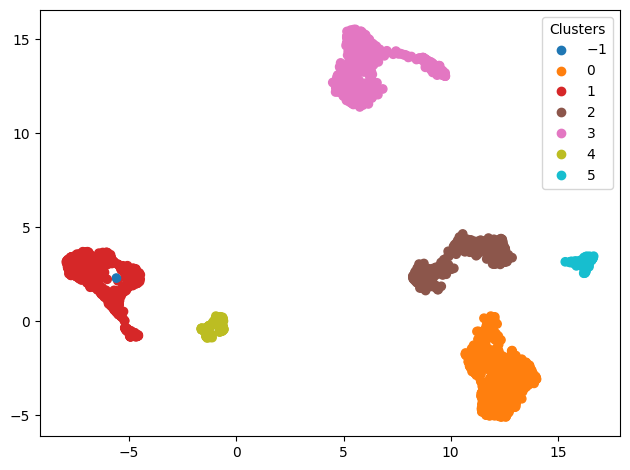

In [39]:
hdb = DBSCAN(eps=0.4) # 0.3 era el valor en el ejemplo
y = hdb.fit(embedding_rf)

scatter = plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')

plt.legend(*scatter.legend_elements(), title="Clusters")

plt.tight_layout()
plt.show()

In [17]:
# Create a 3D scatter plot with no color distinction
fig = go.Figure(data=[go.Scatter3d(
    x=embedding_rf[:, 0],
    y=embedding_rf[:, 1],
    z=embedding_rf[:, 2],
    mode='markers',
    marker=dict(
        size=5,   # Adjust point size
        color=y.labels_,  # Single color for all points
        opacity=0.8
    )
)])

# Set labels and make the plot larger
fig.update_layout(
    title='3D Scatter Plot of Embeddings',
    scene=dict(
        xaxis_title='Dimension 0',
        yaxis_title='Dimension 1',
        zaxis_title='Dimension 2'
    ),
    width=800,  # Make the plot bigger
    height=600
)

# Show the plot
fig.show()

In [40]:
pd.Series(y.labels_).value_counts() # los que tienen -1 son outliers que no fueron asignados a ningun cluster

 0    1142
 3    1022
 1     981
 2     694
 4     175
 5     156
-1       1
Name: count, dtype: int64

Entonces ahora lo que quiero es volver a juntar Xtrain_rf con ytrain_rf y agregar la columna con el cluster asignado

In [41]:
print(type(Xtrain_rf), Xtrain_rf.shape)
print(type(ytrain_rf), ytrain_rf.shape)
pd.Series(y.labels_).shape

<class 'pandas.core.frame.DataFrame'> (4171, 855)
<class 'pandas.core.series.Series'> (4171,)


(4171,)

In [42]:
Xtrain_rf = Xtrain_rf.reset_index(drop=True)
ytrain_rf = ytrain_rf.reset_index(drop=True)

merged_df = pd.concat([Xtrain_rf, 
                        ytrain_rf.rename('clase_ternaria'),  # Rename the Series
                        pd.Series(y.labels_.astype(int), name='cluster')],  # Create a Series with a name
                       axis=1)

# Check the shape and the first few rows of the merged DataFrame
print(merged_df.shape)
merged_df.head(10)

(4171, 857)


,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,tarjetas_mpagominimo_comp,tarjetas_mfinanciacion_limite_comp,matm_total_comp,tchannel,any_delinquency,total_delinquency,Master_status_v2,Visa_status_v2,clase_ternaria,cluster
0,258586107,202104,1,0,1,66,93,3352.51,25616.29,2652.27,...,-1,-1,0,0,0,0,NaN,20.0,1,0
1,261982034,202104,0,0,1,63,162,1893.31,9803.34,1592.20,...,0,0,0,0,0,0,0.0,0.0,1,0
2,267630599,202104,1,0,0,52,295,3824.22,45969.60,1881.16,...,-1,0,1,1,0,0,0.0,0.0,0,1
3,269475506,202104,1,0,0,49,56,21477.54,160819.88,1592.20,...,0,0,0,0,0,0,NaN,NaN,1,0
4,274751781,202104,1,0,0,68,277,2190.65,28088.05,2382.89,...,-1,0,0,0,0,0,0.0,0.0,1,2
5,277239901,202104,0,0,0,45,37,2890.69,25030.16,1592.20,...,0,0,0,0,0,0,5.0,5.0,1,0
6,277333470,202104,1,0,0,65,98,-4220.57,-5188.78,3760.66,...,1,0,-1,1,0,0,0.0,0.0,0,3
7,280872106,202104,1,0,0,71,261,22988.33,206980.64,1831.56,...,1,0,0,1,0,0,NaN,0.0,0,3
8,281365096,202104,1,0,0,44,99,2240.31,17355.29,2295.24,...,-1,0,0,1,0,0,0.0,0.0,0,1
9,282482708,202104,1,0,0,55,265,2052.92,22209.27,2443.44,...,1,0,-1,1,0,0,0.0,0.0,0,3


In [43]:
merged_df.groupby('cluster')['clase_ternaria'].value_counts().unstack(fill_value=0)

clase_ternaria,0,1
cluster,,
-1,1,0
0,70,1072
1,925,56
2,212,482
3,617,405
4,128,47
5,47,109


In [44]:
# Create a new DataFrame to hold the counts
results = merged_df.groupby('cluster')['clase_ternaria'].value_counts().unstack(fill_value=0)

# Rename the columns for clarity
results.columns = ['continua', 'baja']

# Calculate the total and prob_baja
results['total'] = results['baja'] + results['continua']
results['prob_baja'] = results['baja'] / results['total']

# Reset index to convert the result back to a DataFrame
results.reset_index(inplace=True)

# Sort the DataFrame by 'bajas' in descending order
results.sort_values(by='prob_baja', ascending=False, inplace=True)

total = results[['total','continua','baja','total']].sum()

print(total)

results

total       4171
continua    2000
baja        2171
total       4171
dtype: int64


,cluster,continua,baja,total,prob_baja
1,0,70,1072,1142,0.938704
6,5,47,109,156,0.698718
3,2,212,482,694,0.694524
4,3,617,405,1022,0.396282
5,4,128,47,175,0.268571
2,1,925,56,981,0.057085
0,-1,1,0,1,0.000000


In [50]:
clusters_baja = [0,5,2]

### Variables de separacion

In [45]:
df_embedding = pd.DataFrame(embedding_rf)
df_embedding['cluster'] = y.labels_
df_embedding

,0,1,cluster
0,11.991887,-4.596934,0
1,13.269317,-3.623019,0
2,-7.317590,2.503281,1
3,11.843009,-4.823502,0
4,10.980402,3.780539,2
...,...,...,...
4166,12.102443,3.260807,2
4167,11.552502,-4.077157,0
4168,12.841471,-4.387033,0
4169,5.454407,11.764935,3


Usaremos random forests para ver que variables son las que distinguen a cada cluster respecto de los demas.

In [46]:
clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int) # arma un vector de 0 y 1 segun es el cluster o no, entonces despues trata de predecir ese cluster

  model = RandomForestClassifier(random_state=semillas[2])
  model.fit(Xtrain_rf, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

In [51]:
unique_features = set()
top_features_by_cluster = {}  # Initialize an empty dictionary

for cluster, features in important_features_by_cluster.items():
    # print(f"Cluster {cluster} vs. Resto:")
    # Add the top 10 features to the dictionary with the cluster as the key
    top_features_by_cluster[cluster] = features[:10]  # Store the top features

    for feature in features[:10]:
        # print(f"  - {feature}")
        if cluster in clusters_baja:
            unique_features.add(feature)  # Add the feature to the set

# Convert the set to a list
unique_features_list = list(unique_features)
unique_features_list

['suma_alt',
 'slope_avg3_mprestamos_personales',
 'mcaja_ahorro',
 'mpasivos_margen',
 'mprestamos_personales',
 'avg3_mcaja_ahorro',
 'avg3_ctrx_quarter',
 'consumos_mas_DA',
 'avg3_mautoservicio',
 'ctrx_quarter',
 'avg3_mpasivos_margen',
 'mprestamos_personales_comp',
 'tarjetas_mpagospesos',
 'avg3_mprestamos_personales',
 'avg3_cprestamos_personales',
 'cprestamos_personales',
 'avg3_Visa_mpagospesos',
 'avg3_ctarjeta_debito_transacciones',
 'mtarjeta_total_consumo',
 'slope_mprestamos_personales']

In [52]:
for cluster in top_features_by_cluster:
    print(f"Top features for Cluster {cluster}: {top_features_by_cluster[cluster]}")

Top features for Cluster 0: ['mcaja_ahorro', 'suma_alt', 'avg3_mpasivos_margen', 'ctrx_quarter', 'avg3_ctrx_quarter', 'avg3_Visa_mpagospesos', 'avg3_mcaja_ahorro', 'mtarjeta_total_consumo', 'tarjetas_mpagospesos', 'consumos_mas_DA']
Top features for Cluster 1: ['avg3_mpayroll', 'mpayroll', 'avg3_mpayroll_todos', 'mpayroll_todos', 'cpayroll_trx', 'slope_mpayroll', 'slope_avg3_mpayroll', 'ctrx_quarter', 'avg3_cpayroll_trx', 'mpayroll_comp']
Top features for Cluster 2: ['ctrx_quarter', 'avg3_ctrx_quarter', 'mpasivos_margen', 'mcaja_ahorro', 'avg3_mpasivos_margen', 'avg3_ctarjeta_debito_transacciones', 'consumos_mas_DA', 'avg3_mcaja_ahorro', 'suma_alt', 'avg3_mautoservicio']
Top features for Cluster 3: ['ctrx_quarter', 'mpayroll_todos', 'avg3_ctrx_quarter', 'cpayroll_trx', 'avg3_cpayroll_trx', 'avg3_mpayroll_todos', 'avg3_mpayroll', 'mpayroll', 'slope_avg3_mpayroll', 'slope_mpayroll']
Top features for Cluster 4: ['ctrx_quarter', 'avg3_ctrx_quarter', 'avg3_mpayroll', 'mpayroll', 'mpayroll_t

In [53]:
for cluster in clusters_baja:
    print(f"Top features for Cluster {cluster}: {top_features_by_cluster[cluster]}")

Top features for Cluster 0: ['mcaja_ahorro', 'suma_alt', 'avg3_mpasivos_margen', 'ctrx_quarter', 'avg3_ctrx_quarter', 'avg3_Visa_mpagospesos', 'avg3_mcaja_ahorro', 'mtarjeta_total_consumo', 'tarjetas_mpagospesos', 'consumos_mas_DA']
Top features for Cluster 5: ['avg3_mprestamos_personales', 'avg3_cprestamos_personales', 'mprestamos_personales', 'cprestamos_personales', 'slope_mprestamos_personales', 'slope_avg3_mprestamos_personales', 'mprestamos_personales_comp', 'avg3_ctrx_quarter', 'avg3_mpasivos_margen', 'mcaja_ahorro']
Top features for Cluster 2: ['ctrx_quarter', 'avg3_ctrx_quarter', 'mpasivos_margen', 'mcaja_ahorro', 'avg3_mpasivos_margen', 'avg3_ctarjeta_debito_transacciones', 'consumos_mas_DA', 'avg3_mcaja_ahorro', 'suma_alt', 'avg3_mautoservicio']


Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.

### EDA

#### Demograficas

No hay diferencias interesantes

In [72]:
merged_df.groupby('cluster').agg({
    'cliente_edad': 'mean',
    'cliente_antiguedad': 'mean'
})

,cliente_edad,cliente_antiguedad
cluster,,
-1,31.000000,70.000000
0,47.148862,98.387916
1,42.867482,129.392457
2,51.540346,121.984150
3,49.211350,141.267123
4,48.291429,92.725714
5,49.096154,102.217949


#### Rentabilidad y comisiones

Primero podemos comenzar viendo la rentabilidad de los segmentos para ver si todos son de interes para el banco o no

In [74]:
merged_df.groupby('cluster').agg({
    'mrentabilidad': 'mean',
    'avg3_mrentabilidad': 'mean',
    'mcomisiones': 'mean',
    'mactivos_margen': 'mean',
    'mpasivos_margen': 'mean'
})

,mrentabilidad,avg3_mrentabilidad,mcomisiones,mactivos_margen,mpasivos_margen
cluster,,,,,
-1,-923.660000,-1021.583333,1038.060000,-2424.820000,752.410000
0,2818.711278,2835.339780,1319.033021,1228.368643,50.129335
1,1545.418767,1450.305528,918.295464,-1066.891916,1601.521213
2,1681.538545,1504.363043,1529.575893,-330.706441,460.255793
3,2526.332065,2773.134954,1999.190910,-1286.305372,1735.699374
4,1171.725600,1254.269438,578.121771,-334.089314,840.143886
5,3399.638846,3030.680919,1521.835833,1563.737692,37.116923


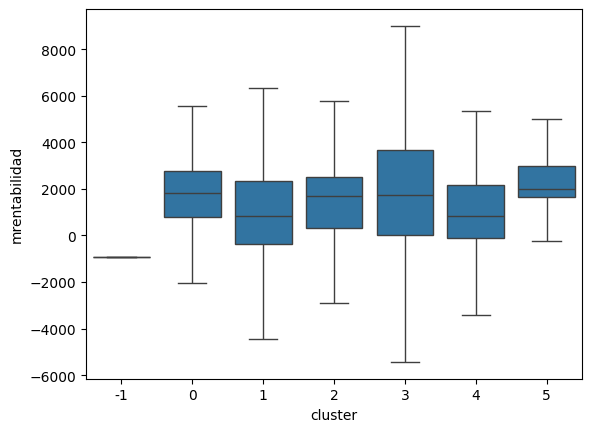

In [88]:
sns.boxplot(x='cluster', y='mrentabilidad', data=merged_df,showfliers=False)
plt.show()

In [68]:
merged_df.groupby('cluster')['mrentabilidad'].apply(lambda x: (x < 0).mean() * 100)

cluster
-1    100.000000
 0      7.267951
 1     30.682977
 2     16.858790
 3     24.951076
 4     26.857143
 5      8.333333
Name: mrentabilidad, dtype: float64

El segmento 2 es el de menor rentabilidad, aun asi tienen una rentabilidad promedio positiva. 

Es interesante que a diferencia de los otros 2 segmentos el banco obtiene ganancias por el dinero/inversiones que el cliente tiene en el banco, mientras que tiene un margen negativo
en concepto del monto total de la ganancia que el banco ha obtenido en concepto de intereses que ha cobrado al cliente.

In [113]:
# merged_df.groupby('cluster')['cliente_vip'].apply(lambda x: (x == 1).mean() * 100)

#### Uso de productos y cuentas

In [127]:
merged_df.groupby('cluster').agg({
    'cproductos': 'mean',
    'tcuentas': 'mean',
    'ccuenta_corriente': 'mean',
    'ccaja_ahorro': 'mean',
    'ctarjeta_debito': 'mean',
    'ctarjeta_visa':'mean', # OJO que CREO no es cantidad de tarjetas visa
    'ctarjeta_master':'mean',
    'ctarjeta_total':'mean',
    'cprestamos_personales':'mean',
    # 'cprestamos_prendarios': 'mean',
    # 'cprestamos_hipotecarios': 'mean'
    'cplazo_fijo':'mean',
    'cinversion1':'mean',
    'cinversion2':'mean',
    # 'cseguro_todos':'mean',
    # 'cseguro_vida':'mean',
    # 'cseguro_auto':'mean',
    'ccaja_seguridad':'mean',
    'ccuenta_debitos_automaticos':'mean',
    'ctrx_quarter':'mean'
})

,cproductos,tcuentas,ccuenta_corriente,ccaja_ahorro,ctarjeta_debito,ctarjeta_visa,ctarjeta_master,ctarjeta_total,cprestamos_personales,cplazo_fijo,cinversion1,cinversion2,ccaja_seguridad,ccuenta_debitos_automaticos,ctrx_quarter
cluster,,,,,,,,,,,,,,,
-1,6.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,184.000000
0,5.655867,1.018389,1.000876,2.091944,1.409807,0.514011,0.470228,1.028021,0.001751,0.009632,0.004378,0.014011,0.018389,0.116462,9.544658
1,7.648318,1.000000,1.000000,2.098879,1.424057,0.959225,0.915392,1.918451,0.962283,0.325178,0.047910,0.109072,0.037717,1.193680,144.883792
2,6.867435,1.012968,1.002882,2.125360,1.487032,0.939481,0.855908,1.878963,0.108069,0.061960,0.017291,0.033141,0.044669,0.308357,29.243516
3,7.388454,1.000978,1.003914,2.223092,1.548924,0.939335,0.880626,1.878669,0.523483,0.153620,0.035225,0.146771,0.081213,1.200587,137.769080
4,6.817143,1.005714,1.000000,2.165714,1.451429,0.885714,0.828571,1.771429,0.862857,0.068571,0.000000,0.011429,0.040000,0.360000,35.720000
5,6.230769,1.000000,1.000000,2.064103,1.391026,0.493590,0.320513,0.987179,5.378205,0.012821,0.006410,0.000000,0.012821,0.102564,16.192308


Practicamente todos los del segmento 2 poseen tarjeta visa y master, mientras que cerca de la mitad de los otros 2 segmentos no poseen tarjeta

In [80]:
# Create a pivot table to calculate the percentage of observations for each cluster and ctarjeta_visa value
pivot_table_visa = (
    merged_df
    .groupby(['cluster', 'ctarjeta_visa'])
    .size()
    .groupby(level=0)  # Group by cluster to calculate the percentages
    .apply(lambda x: x / x.sum() * 100)  # Calculate percentage
    .unstack('ctarjeta_visa', fill_value=0)  # Unstack to make a table
)

# Display the result
pivot_table_visa.round(1)

,ctarjeta_visa,0,1,2,3
cluster,cluster,,,,
-1,-1,0.0,100.0,0.0,0.0
0,0,48.7,51.2,0.1,0.0
1,1,4.6,94.9,0.5,0.0
2,2,6.5,93.1,0.4,0.0
3,3,6.8,92.7,0.5,0.1
4,4,11.4,88.6,0.0,0.0
5,5,50.6,49.4,0.0,0.0


In [85]:
# Create a pivot table to calculate the percentage of observations for each cluster and ctarjeta_visa value
pivot_table_master = (
    merged_df
    .groupby(['cluster', 'ctarjeta_master'])
    .size()
    .groupby(level=0)  # Group by cluster to calculate the percentages
    .apply(lambda x: x / x.sum() * 100)  # Calculate percentage
    .unstack('ctarjeta_master', fill_value=0)  # Unstack to make a table
)

# Display the result
pivot_table_master.round(1)

,ctarjeta_master,0,1,2
cluster,cluster,,,
-1,-1,0.0,100.0,0.0
0,0,53.1,46.8,0.1
1,1,8.6,91.3,0.1
2,2,14.4,85.6,0.0
3,3,12.0,87.9,0.1
4,4,17.1,82.9,0.0
5,5,67.9,32.1,0.0


In [86]:
# Create a pivot table to calculate the percentage of observations for each cluster and ctarjeta_visa value
pivot_table_total = (
    merged_df
    .groupby(['cluster', 'ctarjeta_total'])
    .size()
    .groupby(level=0)  # Group by cluster to calculate the percentages
    .apply(lambda x: x / x.sum() * 100)  # Calculate percentage
    .unstack('ctarjeta_total', fill_value=0)  # Unstack to make a table
)

# Display the result
pivot_table_total.round(1)

,ctarjeta_total,0,2,4,6
cluster,cluster,,,,
-1,-1,0.0,100.0,0.0,0.0
0,0,48.7,51.2,0.1,0.0
1,1,4.6,94.9,0.5,0.0
2,2,6.5,93.1,0.4,0.0
3,3,6.8,92.7,0.5,0.1
4,4,11.4,88.6,0.0,0.0
5,5,50.6,49.4,0.0,0.0


Sin embargo, el segmento 5 es muy proclive a poseer un numero alto de prestamos personales, casi 80% posee al menos 1 prestamos personal, y aproximadamente el 40% posee 3 o mas prestamos
Podriamos considerar entonces que una parte de los clientes que buscan irse a otro banco quizas esten encontrando condiciones de financiamiento mas favorables, y preguntarnos por otra parte quienes son los clientes de este segmento que no tienen ningun prestamo, es gente que decide no utilizar estos productos o que los necesita y como sus solicitudes son rechazadas o encuentra muchas fricciones a la hora de conseguir financiamiento decide irse a otra institucion?.

In [87]:
# Create a pivot table to calculate the percentage of observations for each cluster and ctarjeta_visa value
tabla = (
    merged_df
    .groupby(['cluster', 'cprestamos_personales'])
    .size()
    .groupby(level=0)  # Group by cluster to calculate the percentages
    .apply(lambda x: x / x.sum() * 100)  # Calculate percentage
    .unstack('cprestamos_personales', fill_value=0)  # Unstack to make a table
)

# Display the result
tabla.round(1)

,cprestamos_personales,0,1,2,3,4,5,6,7,8,9,...,39,43,44,54,56,73,79,88,103,108
cluster,cluster,,,,,,,,,,,,,,,,,,,,,
-1,-1,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0,99.8,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,74.6,11.7,5.0,1.7,1.4,1.1,1.1,0.4,0.4,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
2,2,93.8,4.0,1.6,0.1,0.0,0.1,0.0,0.0,0.1,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,85.6,7.4,2.5,1.1,1.4,0.7,0.2,0.1,0.0,0.3,...,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0
4,4,89.7,5.7,1.1,0.6,0.0,1.1,0.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
5,5,20.5,34.0,7.1,2.6,4.5,2.6,3.8,3.8,1.9,4.5,...,0.0,0.0,0.6,0.0,0.6,0.6,0.0,0.6,0.0,0.0


#### Cuenta sueldo

Practicamente ninguno de los 3 segmentos cobra su sueldo en el banco, con lo cual probablemente no tengan bonificada la cuenta

In [115]:
merged_df.groupby('cluster').agg({
    'cpayroll_trx': 'mean',
    'mpayroll':'mean',
    'ctrx_quarter':'mean'
})

,cpayroll_trx,mpayroll,ctrx_quarter
cluster,,,
-1,2.000000,37141.870000,184.000000
0,0.001751,0.905403,9.544658
1,1.740061,143247.400173,144.883792
2,0.002882,0.097853,29.243516
3,0.010763,21.264227,137.769080
4,1.542857,72498.563543,35.720000
5,0.000000,0.000000,16.192308


In [99]:
merged_df.groupby('cluster')['cpayroll_trx'].apply(lambda x: (x == 0).mean() * 100)

cluster
-1      0.000000
 0     99.824869
 1      0.000000
 2     99.711816
 3     99.021526
 4      0.000000
 5    100.000000
Name: cpayroll_trx, dtype: float64

El cluster 0 sobre todo no recibe tampoco transferencias (y menos aun envia), sugiriendo que es un segmento con mucha inactividad. Tampoco usan el cajero

In [107]:
merged_df.groupby('cluster')['ctransferencias_recibidas'].apply(lambda x: (x == 0).mean() * 100)

cluster
-1     0.000000
 0    78.809107
 1    20.081549
 2    53.458213
 3    20.156556
 4    33.142857
 5    60.256410
Name: ctransferencias_recibidas, dtype: float64

In [108]:
merged_df.groupby('cluster')['ctransferencias_emitidas'].apply(lambda x: (x == 0).mean() * 100)

cluster
-1     0.000000
 0    95.008757
 1    25.382263
 2    81.123919
 3    33.659491
 4    64.000000
 5    95.512821
Name: ctransferencias_emitidas, dtype: float64

In [109]:
merged_df.groupby('cluster')['cextraccion_autoservicio'].apply(lambda x: (x == 0).mean() * 100)

cluster
-1     0.000000
 0    97.373030
 1    29.663609
 2    89.625360
 3    63.600783
 4    60.000000
 5    96.794872
Name: cextraccion_autoservicio, dtype: float64

In [112]:
merged_df.groupby('cluster')['ccheques_depositados_rechazados'].apply(lambda x: (x > 0).mean() * 100)

cluster
-1    0.000000
 0    0.087566
 1    0.000000
 2    0.000000
 3    0.489237
 4    0.000000
 5    0.000000
Name: ccheques_depositados_rechazados, dtype: float64

#### Prestamos

In [126]:
merged_df.groupby('cluster').agg({
    'cprestamos_personales': 'mean',
    'mprestamos_personales':'mean'
})

,cprestamos_personales,mprestamos_personales
cluster,,
-1,0.000000,0.000000
0,0.001751,3.391664
1,0.962283,36040.706565
2,0.108069,10088.525663
3,0.523483,20795.935499
4,0.862857,18900.752686
5,5.378205,77882.028141


#### Comisiones

Los segmentos que vimos son muy proclives a pagar comisiones de mantenimiento de cuenta

In [105]:
merged_df.groupby('cluster')['ccomisiones_mantenimiento'].apply(lambda x: (x > 0).mean() * 100)

cluster
-1     0.000000
 0    76.357268
 1     5.402650
 2    70.893372
 3    67.318982
 4    20.000000
 5    78.846154
Name: ccomisiones_mantenimiento, dtype: float64

In [104]:
merged_df.groupby('cluster').agg({
    'ccomisiones_mantenimiento': 'mean',
    'mcomisiones_mantenimiento':'mean',
})

,ccomisiones_mantenimiento,mcomisiones_mantenimiento
cluster,,
-1,0.000000,0.000000
0,0.797723,1416.426357
1,0.062181,55.729847
2,0.736311,1289.923285
3,0.706458,1235.868376
4,0.228571,330.478229
5,0.807692,1492.845577


#### Morosidad

Esto no se la verdad, segmentos 0 y 5 son los que tienen mas morosidad, en el caso del segmento 5 probablemente por otras razones.
Pero tampoco parece ser una locura.

In [116]:
# List of columns to calculate the percentage of values greater than 0
columns = ['Master_delinquency', 'Visa_delinquency']

# Calculate the percentage of values > 0 for each cluster and each column
percentage_df = merged_df.groupby('cluster')[columns].apply(lambda x: (x > 0).mean() * 100)

# Display the result
percentage_df

,Master_delinquency,Visa_delinquency
cluster,,
-1,0.000000,0.000000
0,1.663748,2.889667
1,0.611621,1.121305
2,0.432277,1.008646
3,0.880626,1.174168
4,0.571429,0.571429
5,1.282051,3.205128


#### Tarjetas

In [128]:
merged_df.groupby('cluster').agg({
    'Master_mfinanciacion_limite': 'mean',
    'Visa_mfinanciacion_limite':'mean',
    'Master_msaldototal':'mean',
    'Visa_msaldototal':'mean',
    'Master_mlimitecompra':'mean',
    'Visa_mlimitecompra':'mean',
    'Master_fechaalta':'mean',
    'Visa_fechaalta':'mean',
    'ctarjeta_visa_descuentos':'mean',
    'ctarjeta_master_descuentos':'mean',
})

,Master_mfinanciacion_limite,Visa_mfinanciacion_limite,Master_msaldototal,Visa_msaldototal,Master_mlimitecompra,Visa_mlimitecompra,Master_fechaalta,Visa_fechaalta,ctarjeta_visa_descuentos,ctarjeta_master_descuentos
cluster,,,,,,,,,,
-1,2.533680e+04,76010.400000,21005.200000,69156.320000,28152.000000,84456.000000,1628.000000,1628.000000,0.000000,0.000000
0,3.667657e+05,225299.911338,4493.995693,6890.921928,272925.391018,258517.698360,1917.491150,2312.788489,0.003503,0.003503
1,2.395641e+06,334422.760000,10471.984120,37130.908472,370800.830390,371590.298120,2354.380846,3033.650641,0.114169,0.100917
2,9.225504e+05,279375.283824,2407.253471,15381.042079,305553.856512,310423.151882,2250.100826,3056.740516,0.025937,0.010086
3,2.272784e+06,386835.007556,19918.472413,49301.071595,409400.973402,429655.678548,2729.859783,3408.933538,0.067515,0.089041
4,5.000346e+05,235799.800833,5777.494082,13820.624551,246803.373537,262006.963590,1443.857143,2027.012821,0.017143,0.005714
5,2.042070e+05,184588.505000,16244.270000,9781.016098,232347.813704,209910.258902,2375.574074,2412.439024,0.000000,0.000000


In [125]:
merged_df.groupby('cluster').agg({
    'Master_mconsumototal': 'mean',
    'Master_cconsumos':'mean',
    'Master_cadelantosefectivo':'mean',
    'Visa_mconsumototal': 'mean',
    'Visa_cconsumos':'mean',
    'Visa_cadelantosefectivo':'mean',
})

,Master_mconsumototal,Master_cconsumos,Master_cadelantosefectivo,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo
cluster,,,,,,
-1,3983.260000,2.000000,0.0,8602.770000,2.000000,0.000000
0,1711.092200,0.960000,0.0,1247.158041,1.229730,0.000000
1,7002.828250,2.700000,0.0,19850.140549,8.448430,0.008969
2,4075.141933,1.473333,0.0,9990.763785,3.634652,0.005650
3,13479.144188,3.777778,0.0,26647.853563,9.930032,0.009688
4,3798.417188,0.937500,0.0,7875.087642,2.537736,0.000000
5,601.280000,0.444444,0.0,1516.894667,1.288889,0.000000


#### Proceso de cierre

In [117]:
# Create a pivot table to calculate the percentage of observations for each cluster and ctarjeta_visa value
tabla = (
    merged_df
    .groupby(['cluster', 'Master_status'])
    .size()
    .groupby(level=0)  # Group by cluster to calculate the percentages
    .apply(lambda x: x / x.sum() * 100)  # Calculate percentage
    .unstack('Master_status', fill_value=0)  # Unstack to make a table
)

# Display the result
tabla.round(1)

,Master_status,0.0,6.0,7.0,9.0
cluster,cluster,,,,
-1,-1,100.0,0.0,0.0,0.0
0,0,79.1,1.0,9.7,10.2
1,1,99.9,0.0,0.1,0.0
2,2,98.2,0.0,0.2,1.7
3,3,97.6,0.0,0.2,2.2
4,4,98.6,0.0,0.7,0.7
5,5,92.6,0.0,1.9,5.6


In [119]:
# Create a pivot table to calculate the percentage of observations for each cluster and ctarjeta_visa value
tabla = (
    merged_df
    .groupby(['cluster', 'Visa_status'])
    .size()
    .groupby(level=0)  # Group by cluster to calculate the percentages
    .apply(lambda x: x / x.sum() * 100)  # Calculate percentage
    .unstack('Visa_status', fill_value=0)  # Unstack to make a table
)

# Display the result
tabla.round(1)

,Visa_status,0.0,6.0,7.0,9.0
cluster,cluster,,,,
-1,-1,100.0,0.0,0.0,0.0
0,0,84.2,0.9,6.9,8.1
1,1,100.0,0.0,0.0,0.0
2,2,98.5,0.0,0.0,1.5
3,3,97.3,0.0,0.3,2.4
4,4,99.4,0.0,0.6,0.0
5,5,93.9,0.0,1.2,4.9


In [56]:
for cluster in clusters_baja:
    print(f"Top features for Cluster {cluster}: {top_features_by_cluster[cluster]}")

Top features for Cluster 0: ['mcaja_ahorro', 'suma_alt', 'avg3_mpasivos_margen', 'ctrx_quarter', 'avg3_ctrx_quarter', 'avg3_Visa_mpagospesos', 'avg3_mcaja_ahorro', 'mtarjeta_total_consumo', 'tarjetas_mpagospesos', 'consumos_mas_DA']
Top features for Cluster 5: ['avg3_mprestamos_personales', 'avg3_cprestamos_personales', 'mprestamos_personales', 'cprestamos_personales', 'slope_mprestamos_personales', 'slope_avg3_mprestamos_personales', 'mprestamos_personales_comp', 'avg3_ctrx_quarter', 'avg3_mpasivos_margen', 'mcaja_ahorro']
Top features for Cluster 2: ['ctrx_quarter', 'avg3_ctrx_quarter', 'mpasivos_margen', 'mcaja_ahorro', 'avg3_mpasivos_margen', 'avg3_ctarjeta_debito_transacciones', 'consumos_mas_DA', 'avg3_mcaja_ahorro', 'suma_alt', 'avg3_mautoservicio']


In [58]:
# Group by 'cluster' and calculate the percentage of zero values in 'mcaja_ahorro'
merged_df.groupby('cluster')['mcaja_ahorro'].apply(lambda x: (x == 0).mean() * 100)

cluster
-1     0.000000
 0    67.600701
 1     1.529052
 2    16.714697
 3     7.240705
 4     6.285714
 5    43.589744
Name: mcaja_ahorro, dtype: float64

In [132]:
merged_df.groupby('cluster')['mcuenta_corriente'].apply(lambda x: (x < 0).mean() * 100)

cluster
-1    100.000000
 0     87.653240
 1     46.483180
 2     48.414986
 3     48.043053
 4     34.857143
 5     84.615385
Name: mcuenta_corriente, dtype: float64

#### Features especificas de cada cluster

Cluster 0:

In [ ]:
merged_df.groupby('cluster').agg({
    'mcaja_ahorro': 'mean',
    'suma_alt':'mean',
    'avg3_mpasivos_margen':'mean',
    'ctrx_quarter': 'mean',
    'avg3_Visa_mpagospesos':'mean',
    'avg3_mcaja_ahorro':'mean',
    'mtarjeta_total_consumo':'mean',
    'tarjetas_mpagospesos':'mean',
    'consumos_mas_DA':'mean'
    
})

Cluster 2:

In [136]:
features_2 = ['ctrx_quarter', 'avg3_ctrx_quarter', 'mpasivos_margen', 'mcaja_ahorro', 'avg3_mpasivos_margen', 'avg3_ctarjeta_debito_transacciones', 'consumos_mas_DA', 'avg3_mcaja_ahorro', 'suma_alt', 'avg3_mautoservicio']

agg_dict = {feature: 'mean' for feature in features_2}

result = merged_df.groupby('cluster').agg(agg_dict)

result.round(1)


,ctrx_quarter,avg3_ctrx_quarter,mpasivos_margen,mcaja_ahorro,avg3_mpasivos_margen,avg3_ctarjeta_debito_transacciones,consumos_mas_DA,avg3_mcaja_ahorro,suma_alt,avg3_mautoservicio
cluster,,,,,,,,,,
-1,184.0,180.7,752.4,4714.8,761.4,13.0,60487.1,12133.0,-3346.5,24731.2
0,9.5,11.5,50.1,253.7,69.2,0.2,439.9,1351.8,-8213.0,377.7
1,144.9,144.9,1601.5,92958.3,1521.1,12.8,42617.3,86402.9,188262.1,26327.5
2,29.2,30.6,460.3,23930.0,478.4,0.7,16151.7,25246.8,55141.5,1713.9
3,137.8,138.4,1735.7,73515.8,1771.2,6.8,56752.7,78598.0,148774.0,17055.1
4,35.7,37.2,840.1,58980.6,804.6,2.1,11698.1,57035.8,68487.4,6924.1
5,16.2,17.4,37.1,643.5,49.9,0.2,1123.8,1627.6,-13787.3,573.1


Cluster 5:

In [135]:
features_5 = ['avg3_mprestamos_personales', 'avg3_cprestamos_personales', 'mprestamos_personales', 'cprestamos_personales', 'slope_mprestamos_personales', 'slope_avg3_mprestamos_personales', 'mprestamos_personales_comp', 'avg3_ctrx_quarter', 'avg3_mpasivos_margen', 'mcaja_ahorro']

agg_dict = {feature: 'mean' for feature in features_5}

result = merged_df.groupby('cluster').agg(agg_dict)

result.round(1)


,avg3_mprestamos_personales,avg3_cprestamos_personales,mprestamos_personales,cprestamos_personales,slope_mprestamos_personales,slope_avg3_mprestamos_personales,mprestamos_personales_comp,avg3_ctrx_quarter,avg3_mpasivos_margen,mcaja_ahorro
cluster,,,,,,,,,,
-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.7,761.4,4714.8
0,24.3,0.0,3.4,0.0,-26.9,-137.6,-0.0,11.5,69.2,253.7
1,34665.1,1.0,36040.7,1.0,1850.6,1827.1,-0.1,144.9,1521.1,92958.3
2,9722.9,0.1,10088.5,0.1,538.7,600.2,-0.0,30.6,478.4,23930.0
3,22214.4,0.6,20795.9,0.5,-1010.2,98.3,-0.1,138.4,1771.2,73515.8
4,18759.9,0.8,18900.8,0.9,150.4,45.4,-0.1,37.2,804.6,58980.6
5,87903.3,5.5,77882.0,5.4,-8454.0,-4440.7,-0.5,17.4,49.9,643.5


In [ ]:
merged_df.groupby('cluster').agg({
    'mcaja_ahorro': 'mean',
    'suma_alt':'mean',
    'avg3_mpasivos_margen':'mean',
    'ctrx_quarter': 'mean',
    'avg3_Visa_mpagospesos':'mean',
    'avg3_mcaja_ahorro':'mean',
    'mtarjeta_total_consumo':'mean',
    'tarjetas_mpagospesos':'mean',
    'consumos_mas_DA':'mean'
    
})

En cuanto a rentabilidad el segmento 5 es el de mayor rentabilidad promedio, con lo cual seria de interes para el banco mantenerlos.

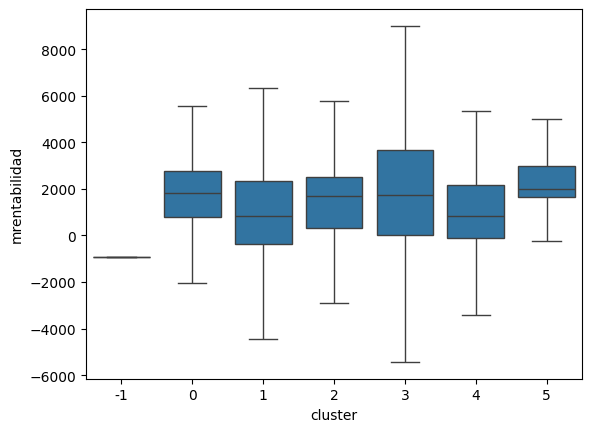

In [64]:
sns.boxplot(x='cluster', y='mrentabilidad', data=merged_df,showfliers=False)
plt.show()

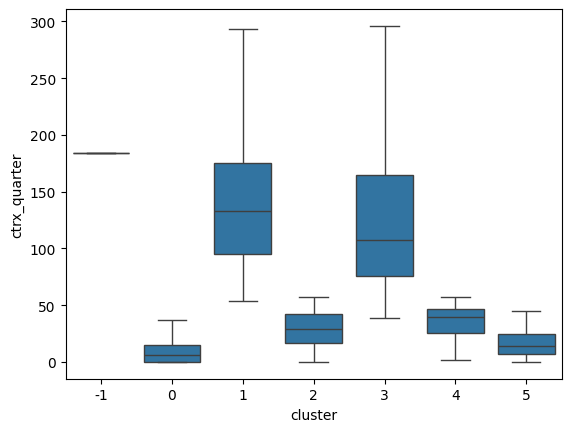

In [65]:
sns.boxplot(x='cluster', y='ctrx_quarter', data=merged_df,showfliers=False)
plt.show()

# El segmento 0 es el que menos transacciones realiza

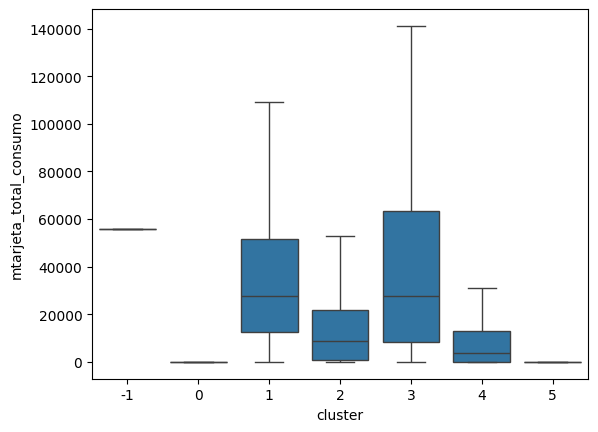

In [66]:
sns.boxplot(x='cluster', y='mtarjeta_total_consumo', data=merged_df,showfliers=False)
plt.show()

### OLDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD

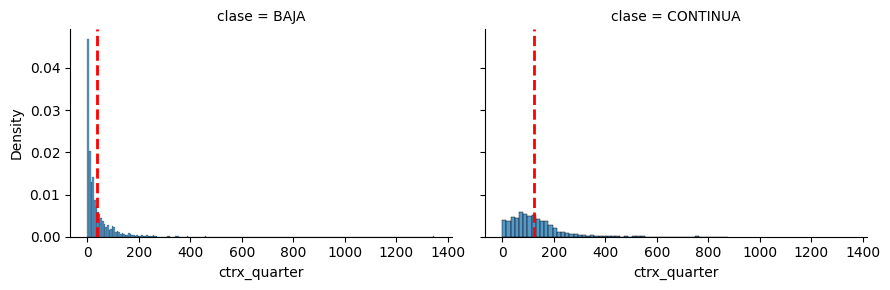

In [44]:
g = sns.FacetGrid(merged_df, col="clase", height=3, aspect=1.5)
g.map(sns.histplot, "ctrx_quarter", stat='density')

# Add the mean line to each facet
for ax, (_, subset) in zip(g.axes.flat, merged_df.groupby("clase")):
    mean_val = subset["ctrx_quarter"].mean()
    ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)

In [45]:
pd.crosstab(merged_df['Visa_status'], merged_df['cluster'])

cluster,-1,0,1,2,3,4,5
Visa_status,,,,,,,
0.0,6,1041,938,800,269,153,148
6.0,0,6,0,0,0,0,0
7.0,0,49,0,1,0,1,2
9.0,0,67,1,1,0,0,24


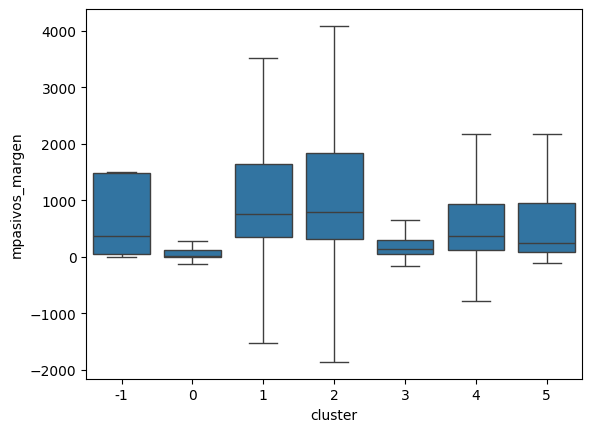

In [59]:
sns.boxplot(x='cluster', y='mpasivos_margen', data=merged_df,showfliers=False)
plt.show()

In [49]:
merged_df.groupby("cluster")[["mpasivos_margen","mrentabilidad"]].describe()

mpasivos_margen                                                \
                  count         mean          std       min       25%   
cluster                                                                 
-1                  8.0  1387.352500  2462.146677      0.19   54.3775   
 0               1711.0   186.804810   778.740854 -11344.74    0.2100   
 1                984.0  1597.866291  4824.250376 -24706.70  358.8025   
 2                805.0  1711.984360  3407.364099  -4353.50  313.9100   
 3                272.0   214.814412   361.418611  -1659.04   56.9350   
 4                173.0   853.519942  1620.908694  -4888.10  116.6400   
 5                218.0  1779.596147  4915.711127   -117.67   87.8225   

                                       mrentabilidad               \
             50%        75%        max         count         mean   
cluster                                                             
-1       370.450  1487.2825    7275.75           8.0  3123.571250   
 0        18.370   114.0000   12614.73        1711.0  2638.347469   
 1       762.110  1634.8350  129027.76         984.0  1510.106067   
 2       784.650  1836.8700   50783.21         805.0  2022.117056   
 3       134.525   301.0025    2504.87         272.0  1294.624706   
 4       364.390   939.7000   10419.03         173.0  1148.744220   
 5       243.325   950.4400   31061.66         218.0  4654.012982   

                                                                            
                 std        min        25%       50%        75%        max  
cluster                                                                     
-1       4887.825900   -4929.59  1539.0550  1849.925  5443.5500   12244.21  
 0       6524.440438  -18731.15   598.3000  1832.200  2716.5300  155423.83  
 1       7306.485255  -39222.94  -388.3050   830.905  2351.2875  151777.07  
 2       7257.533936 -109257.54  -307.7900  1559.620  3755.8600   59596.68  
 3       2304.014756  -10507.78   236.1975  1537.640  2391.7650   11532.06  
 4       2812.046013   -8621.74  -115.3700   804.540  2151.1200   12644.02  
 5       9081.400773   -5761.92   757.1975  2061.385  3643.3100   65146.10

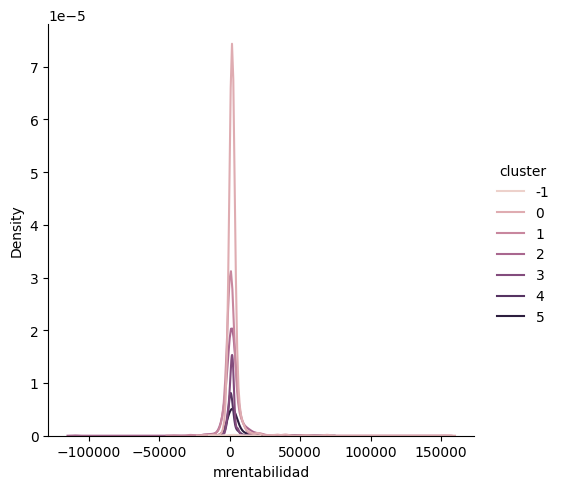

In [67]:
sns.displot(data=merged_df, x="mrentabilidad", hue="cluster", kind="kde");

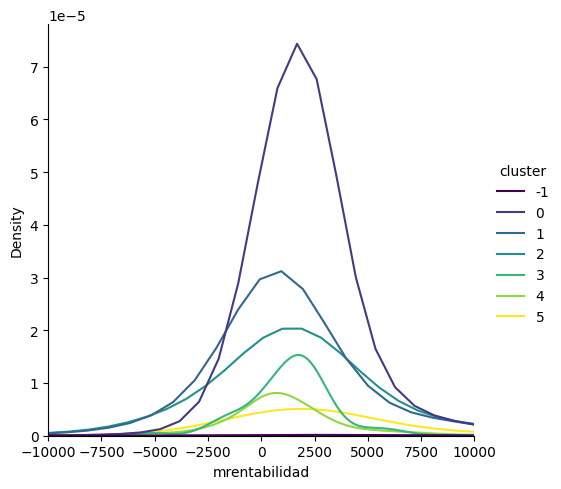

In [70]:
sns.displot(data=merged_df, x="mrentabilidad", hue="cluster", kind="kde", palette="viridis")

# Adjust x-axis limits
plt.xlim(-10000, 10000)  # Adjust based on your data

# Show the plot
plt.show()